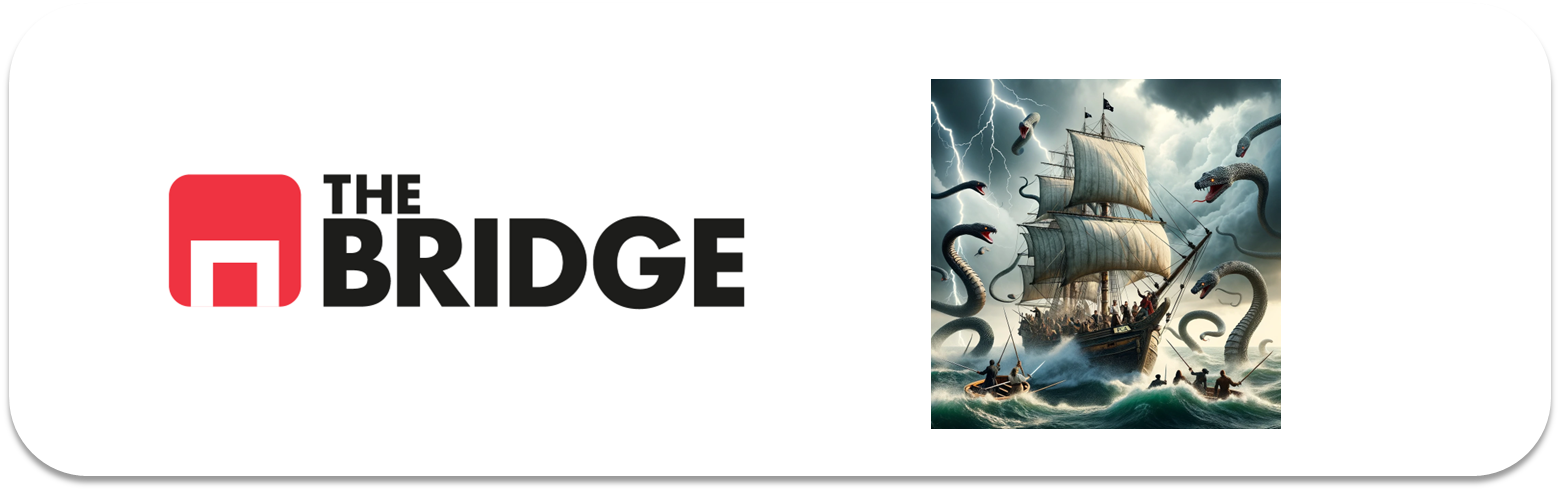

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score


### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [25]:
# 1) Cargar dataset (caras de Olivetti)
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)

X = olivetti.data          # (n_samples, n_pixels=4096)
y = olivetti.target        # 40 clases (0..39)
images = olivetti.images   # (n_samples, 64, 64)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("n_classes:", len(np.unique(y)))

# 2) DataFrame de píxeles
df = pd.DataFrame(X, columns=[f"px_{i}" for i in range(X.shape[1])])
df["target"] = y

df.head()


X shape: (400, 4096)
y shape: (400,)
n_classes: 40


,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_4087,px_4088,px_4089,px_4090,px_4091,px_4092,px_4093,px_4094,px_4095,target
0,0.198347,0.235537,0.351240,0.409091,0.421488,0.429752,0.500000,0.528926,0.524793,0.553719,...,0.508264,0.524793,0.504132,0.483471,0.471074,0.285124,0.061983,0.128099,0.090909,20
1,0.185950,0.128099,0.115702,0.132231,0.185950,0.268595,0.433884,0.541322,0.570248,0.586777,...,0.396694,0.409091,0.301653,0.421488,0.462810,0.247934,0.190083,0.210744,0.210744,28
2,0.508264,0.603306,0.619835,0.628099,0.657025,0.665289,0.690083,0.727273,0.743802,0.768595,...,0.301653,0.305785,0.314050,0.326446,0.338843,0.330579,0.334711,0.342975,0.342975,3
3,0.136364,0.140496,0.185950,0.280992,0.318182,0.363636,0.409091,0.417355,0.438017,0.454545,...,0.169421,0.206612,0.276859,0.355372,0.685950,0.661157,0.280992,0.371901,0.276859,21
4,0.652893,0.644628,0.652893,0.706612,0.714876,0.719008,0.743802,0.747934,0.747934,0.756198,...,0.074380,0.074380,0.082645,0.082645,0.111570,0.070248,0.086777,0.185950,0.231405,9


In [26]:
df.info()
df.describe().T.head(10)
df["target"].value_counts().sort_index().head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 4097 entries, px_0 to target
dtypes: float32(4096), int64(1)
memory usage: 6.3 MB


target
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
Name: count, dtype: int64

In [27]:
# Split train/test - El notebook exige: test con al menos 80 instancias y estratificado.

X_all = df.drop(columns="target").values
y_all = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=80,          # mínimo 80 en test (exacto)
    stratify=y_all,
    random_state=42
)

X_train.shape, X_test.shape


((320, 4096), (80, 4096))

Nulos totales: 0


target
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
Name: count, dtype: int64

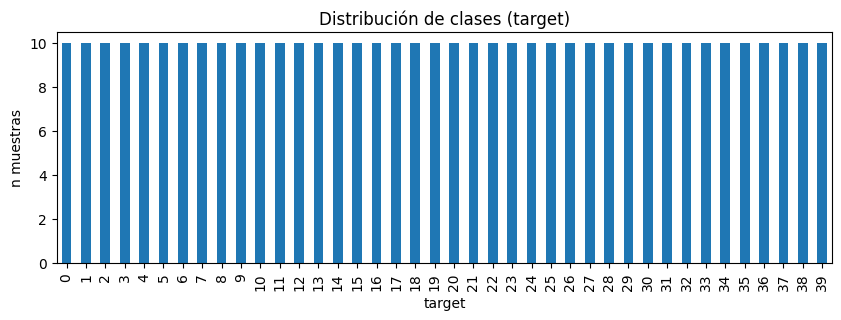

In [28]:
# MiniEDA (correlación numérica + variables “no numéricas” + distribuciones)
# Nulos
print("Nulos totales:", np.isnan(df).sum().sum())

# Target como categórica
target_counts = df["target"].value_counts().sort_index()
display(target_counts.head(10))

plt.figure(figsize=(10,3))
target_counts.plot(kind="bar")
plt.title("Distribución de clases (target)")
plt.ylabel("n muestras")
plt.show()



El dataset no presenta valores nulos, por lo que no es necesario realizar imputación de datos.
La variable target está perfectamente balanceada, ya que todas las clases contienen el mismo número de muestras (10 imágenes por persona).
Esto es positivo para el entrenamiento, ya que evita sesgos hacia determinadas clases y permite usar métricas estándar sin necesidad de técnicas de balanceo.

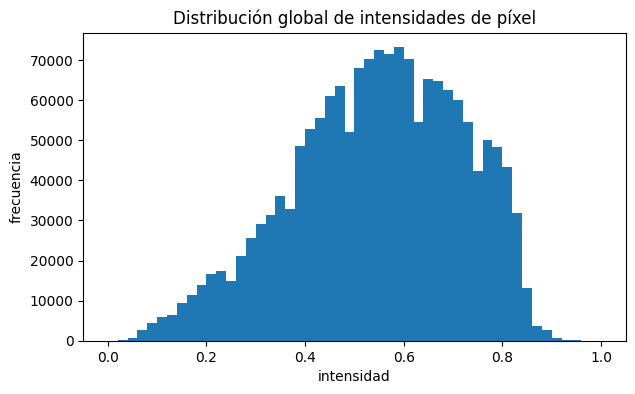

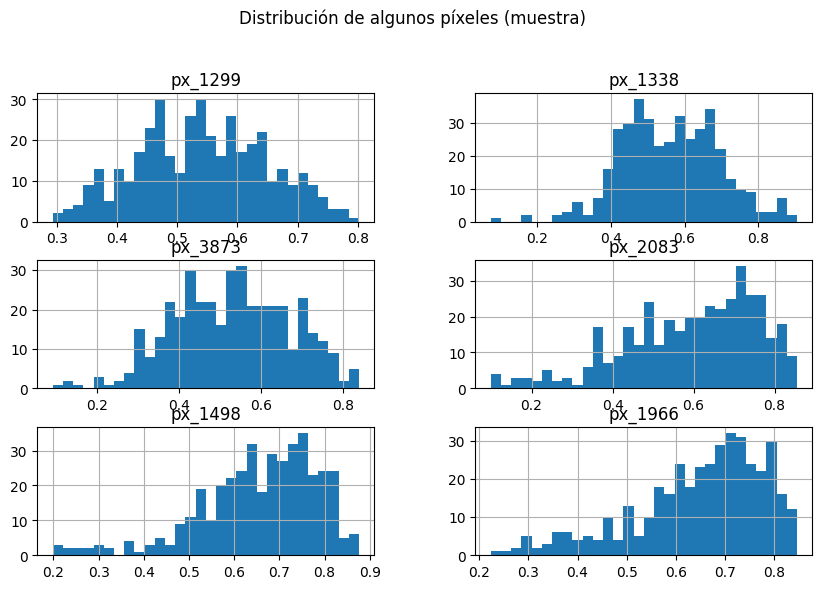

In [29]:
# Distribución de variables numéricas (píxeles)
# Distribución global de intensidades (todos los píxeles juntos)
plt.figure(figsize=(7,4))
plt.hist(X_all.ravel(), bins=50)
plt.title("Distribución global de intensidades de píxel")
plt.xlabel("intensidad")
plt.ylabel("frecuencia")
plt.show()

# Algunas columnas (píxeles) para ver forma
np.random.seed(42)
sample_cols = np.random.choice(df.drop(columns="target").columns, size=6, replace=False)

df[sample_cols].hist(bins=30, figsize=(10,6))
plt.suptitle("Distribución de algunos píxeles (muestra)", y=1.02)
plt.show()


La distribución global de intensidades muestra una forma aproximadamente normal centrada en valores intermedios, indicando predominio de tonos grises en las imágenes. Existe variabilidad suficiente en los datos, lo que justifica el uso de PCA para capturar las principales direcciones de varianza. Aunque las intensidades están normalizadas entre 0 y 1, es necesario estandarizar las variables antes de aplicar PCA para igualar su escala y varianza.

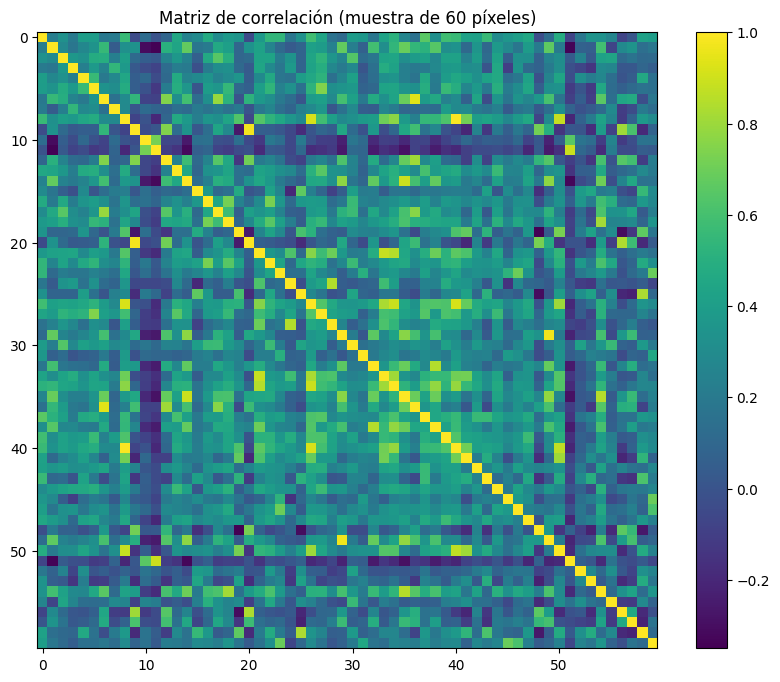

In [30]:
# Correlación entre variables numéricas
# muchas variables, alta redundancia → PCA tiene sentido.
# Correlación en una muestra de píxeles
np.random.seed(42)
corr_cols = np.random.choice(df.drop(columns="target").columns, size=60, replace=False)

corr = df[corr_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.title("Matriz de correlación (muestra de 60 píxeles)")
plt.colorbar()
plt.show()


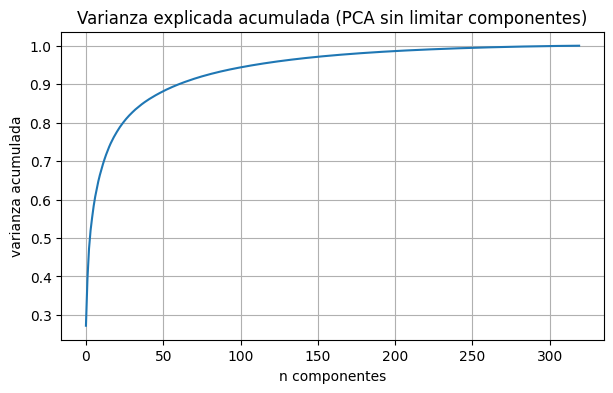

(array([0.2719467 , 0.39559096, 0.4724912 , 0.519825  , 0.55315876,
        0.58322006, 0.60775834, 0.6281604 , 0.6472807 , 0.6636792 ],
       dtype=float32),
 np.float32(1.0000007))

In [31]:
# Estandarizar + PCA (base para las siguientes partes)

scaler = StandardScaler()                        # crear objeto para estandarizar (media=0, varianza=1)
X_train_sc = scaler.fit_transform(X_train)      # ajusta el scaler SOLO con train y transforma train
X_test_sc = scaler.transform(X_test)            # transforma test usando parámetros aprendidos en train

# PCA completo (sin limitar número de componentes)
pca_full = PCA()                                 # crear PCA sin definir n_components
pca_full.fit(X_train_sc)                         # aprender direcciones principales del dataset

# Varianza explicada
explained = pca_full.explained_variance_ratio_   # varianza explicada por cada componente PCA
cum_explained = np.cumsum(explained)             # suma acumulada de varianza explicada

# Visualización curva varianza acumulada
plt.figure(figsize=(7,4))                        # tamaño de la figura
plt.plot(cum_explained)                          # curva acumulada
plt.title("Varianza explicada acumulada (PCA sin limitar componentes)")
plt.xlabel("n componentes")                      # eje X = número de componentes PCA
plt.ylabel("varianza acumulada")                 # eje Y = porcentaje información acumulada
plt.grid(True)                                   # añadir rejilla
plt.show()

# Ver valores iniciales y total acumulado
cum_explained[:10], cum_explained[-1]            # primeras 10 varianzas acumuladas y total final (≈1.0)


Por ejemplo (aprox según la curva):  
~10 componentes → ya capturan bastante información.  
~50 componentes → ≈ 90% varianza.  
~100 componentes → ≈ 95%.  
Después crece muy lento.  
Esto indica:  
👉 Muchísima redundancia entre píxeles.  
La curva de varianza explicada acumulada muestra un crecimiento rápido en los primeros componentes, indicando que gran parte de la información del dataset está concentrada en pocas dimensiones. Esto sugiere una alta correlación entre los píxeles y confirma que PCA puede reducir significativamente la dimensionalidad manteniendo la mayor parte de la varianza.

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [33]:
# ⭐ Validación cruzada (Cross Validation)
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds estratificados - 


In [ ]:
# ---------------------------------------------------------
# MODELO BASELINE (sin PCA)
# ---------------------------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

# Creamos pipeline SIN PCA
baseline_model = Pipeline(steps=[
    ("scaler", StandardScaler()),          # estandarizar datos → PCA y modelos lineales funcionan mejor
    ("clf", LogisticRegression(max_iter=3000))  # clasificador base (modelo simple de referencia)
])

# Evaluación con validación cruzada
baseline_cv_scores = cross_val_score(
    baseline_model,
    X_train,
    y_train,
    cv=cv,                    # usamos StratifiedKFold → mantiene proporción de clases
    scoring="recall_macro"    # recall medio entre clases (evita sesgo entre clases)
)

baseline_cv = baseline_cv_scores.mean()   # promedio del rendimiento en los 5 folds

# Entrenar modelo con TODO el conjunto train
baseline_model.fit(X_train, y_train)      # entrenamos modelo final usando todos los datos de entrenamiento

# Evaluar en test (datos nunca vistos)
baseline_pred = baseline_model.predict(X_test)   # predicciones en test
baseline_test = recall_score(
    y_test,
    baseline_pred,
    average="macro"        # recall medio final para comparar luego con PCA
)

print("Baseline CV:", baseline_cv)
print("Baseline TEST:", baseline_test)


In [ ]:
# ------------------------------------------------
# MODELO BASELINE (sin PCA)
# ------------------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

# Creamos pipeline SIN PCA
baseline_model = Pipeline(steps=[
    ("scaler", StandardScaler()),           # estandarizar datos
    ("clf", LogisticRegression(max_iter=3000))  # clasificador
])

# Evaluación con validación cruzada (recall medio)
baseline_cv_scores = cross_val_score(
    baseline_model,
    X_train,
    y_train,
    cv=cv,
    scoring="recall_macro"   # recall medio (lo que pide el enunciado)
)

baseline_cv = baseline_cv_scores.mean()   # promedio CV

# Entrenar con todo el train
baseline_model.fit(X_train, y_train)

# Evaluar en test
baseline_pred = baseline_model.predict(X_test)
baseline_test = recall_score(y_test, baseline_pred, average="macro")

print("Baseline CV:", baseline_cv)
print("Baseline TEST:", baseline_test)


Baseline CV: 0.9525
Baseline TEST: 0.975


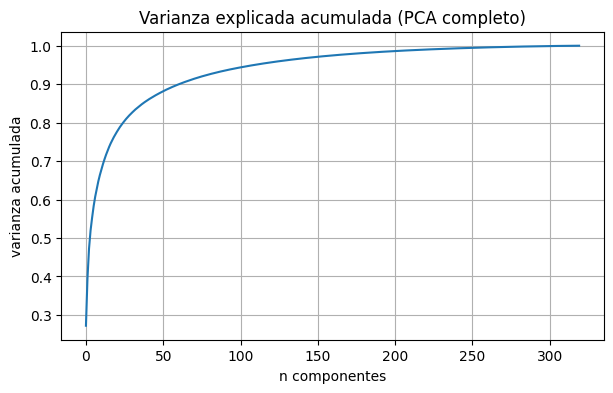

In [35]:
# Paso 1) PCA “sin argumentos” (solo para analizar varianza)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 1) Escalamos (PCA funciona mejor si cada feature tiene media 0 y varianza 1)
scaler = StandardScaler()                                  # crea el escalador
X_train_sc = scaler.fit_transform(X_train)                 # ajusta en train y transforma

# 2) PCA sin argumentos (PCA "completo")
pca_full = PCA()                                           # sin pasar n_components
pca_full.fit(X_train_sc)                                   # aprende los componentes

# 3) Varianza explicada acumulada
cum_explained = np.cumsum(pca_full.explained_variance_ratio_)  # suma acumulada

plt.figure(figsize=(7,4))
plt.plot(cum_explained)                                    # curva acumulada
plt.title("Varianza explicada acumulada (PCA completo)")
plt.xlabel("n componentes")
plt.ylabel("varianza acumulada")
plt.grid(True)
plt.show()


“Se observa que con pocos componentes se captura gran parte de la varianza, lo que justifica usar PCA para comprimir.”

In [36]:
# Paso 2) Elegir 5 valores de n_components que den compresión 0.2%–2.5%
n_features = X_train.shape[1]                # número de píxeles (4096)
candidates = [8, 16, 32, 64, 96]             # 5 valores dentro del rango pedido

# (Opcional) Ver % compresión de cada uno
for n in candidates:
    print(n, "->", (n / n_features) * 100, "%")


8 -> 0.1953125 %
16 -> 0.390625 %
32 -> 0.78125 %
64 -> 1.5625 %
96 -> 2.34375 %


In [37]:
# Paso 3) Entrenar modelo + CV (5 folds) + scoring en test (recall macro)
# Entrenar un clasificador con datos comprimidos con PCA
# Medir recall medio (macro) en CV
# Medir lo mismo en test

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

rows = []  # guardaremos resultados aquí

for n_comp in candidates:
    
    # Pipeline: primero escalar, luego PCA, luego clasificador
    model = Pipeline(steps=[
        ("scaler", StandardScaler()),                           # estandariza
        ("pca", PCA(n_components=n_comp, random_state=42)),     # comprime
        ("clf", LogisticRegression(max_iter=3000))              # clasifica
    ])
    
    # Validación cruzada: "recall_macro" = recall medio entre clases
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="recall_macro"                                  # lo que pide el enunciado
    )
    
    cv_mean = cv_scores.mean()                                  # promedio CV
    
    # Entrenar en todo el train y evaluar en test
    model.fit(X_train, y_train)                                 # entrena
    test_pred = model.predict(X_test)                           # predice
    test_score = recall_score(y_test, test_pred, average="macro")  # recall medio en test
    
    # % compresión: tamaño final / tamaño original
    compression_pct = (n_comp / n_features) * 100
    
    # Guardar fila de resultados
    rows.append({
        "n_components": n_comp,
        "cv_recall_macro": cv_mean,
        "test_recall_macro": test_score,
        "compression_%": compression_pct,
        "diff_cv_vs_baseline": cv_mean - baseline_cv,           # diferencia vs baseline en CV
        "diff_test_vs_baseline": test_score - baseline_test      # diferencia vs baseline en test
    })

results_part2 = pd.DataFrame(rows).sort_values("compression_%")
results_part2


,n_components,cv_recall_macro,test_recall_macro,compression_%,diff_cv_vs_baseline,diff_test_vs_baseline
0,8,0.8075,0.800,0.195312,-1.450000e-01,-0.175
1,16,0.9100,0.925,0.390625,-4.250000e-02,-0.050
2,32,0.9475,0.975,0.781250,-5.000000e-03,0.000
3,64,0.9500,0.975,1.562500,-2.500000e-03,0.000
4,96,0.9525,0.975,2.343750,-1.110223e-16,0.000


Se selecciona n_components = 32 ya que permite una elevada compresión del dataset manteniendo una pérdida inferior a 3 puntos porcentuales respecto al baseline tanto en validación cruzada como en test, cumpliendo así el criterio del enunciado.

In [38]:
# Paso 4) Elegir el mejor según el criterio: máxima compresión con pérdida < 3 puntos
ok_3 = results_part2[
    (results_part2["diff_cv_vs_baseline"] >= -0.03) &
    (results_part2["diff_test_vs_baseline"] >= -0.03)
].copy()

ok_3


,n_components,cv_recall_macro,test_recall_macro,compression_%,diff_cv_vs_baseline,diff_test_vs_baseline
2,32,0.9475,0.975,0.78125,-5.000000e-03,0.0
3,64,0.9500,0.975,1.56250,-2.500000e-03,0.0
4,96,0.9525,0.975,2.34375,-1.110223e-16,0.0


In [39]:
# Si hay candidatos válidos:
best = ok_3.sort_values("compression_%").iloc[0]   # mayor compresión (más pequeño) dentro de la regla
best


n_components             32.00000
cv_recall_macro           0.94750
test_recall_macro         0.97500
compression_%             0.78125
diff_cv_vs_baseline      -0.00500
diff_test_vs_baseline     0.00000
Name: 2, dtype: float64

Se aplicó PCA para comprimir las imágenes y construir un clasificador apto para microcámaras. Se probó un rango de componentes principales que supone una compresión entre 0.2% y 2.5% del tamaño original. Para cada valor se entrenó un pipeline (StandardScaler + PCA + LogisticRegression) y se evaluó mediante validación cruzada estratificada (5 folds) usando recall_macro (recall medio) y también en el conjunto de test. Finalmente se seleccionó el número de componentes que maximiza la compresión manteniendo una pérdida inferior a 3 puntos porcentuales respecto al baseline tanto en CV como en test (o <5 si no existía ninguno). 
Se selecciona PCA con 32 componentes porque logra una compresión del 0.78% del tamaño original y mantiene el rendimiento prácticamente igual al baseline: en CV la pérdida es de 0.005 (0.5 puntos) y en test no hay pérdida (0.975), cumpliendo el criterio de pérdida < 3 puntos porcentuales.

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [40]:
# Preparar baseline en balanced accuracy (para comparar bien)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

# Baseline balanced accuracy (sin PCA) para comparar en esta parte
baseline_bal_model = Pipeline(steps=[
    ("scaler", StandardScaler()),               # estandariza
    ("clf", LogisticRegression(max_iter=3000))  # clasifica
])

baseline_bal_model.fit(X_train, y_train)        # entrena
base_pred = baseline_bal_model.predict(X_test)  # predice
baseline_bal_test = balanced_accuracy_score(y_test, base_pred)  # score baseline

print("Baseline TEST (balanced accuracy):", baseline_bal_test)


Baseline TEST (balanced accuracy): 0.975


In [41]:
# Número total de features originales
n_features = X_train.shape[1]   # 4096

# Valores dentro del rango 0.1% - 1%
candidates_3 = [4, 8, 16, 24, 32]


In [42]:
# Paso 2 — Comprimir → Descomprimir → Entrenar → Evaluar en test (balanced accuracy)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
import pandas as pd

rows3 = []  # aquí guardamos resultados

# 1) Escalar una sola vez (PCA siempre después de escalar)
scaler3 = StandardScaler()                               # crea escalador
X_train_sc = scaler3.fit_transform(X_train)              # ajusta en train y transforma
X_test_sc  = scaler3.transform(X_test)                   # transforma test con lo aprendido en train

for n_comp in candidates_3:
    
    # 2) PCA con n_comp componentes (compresor)
    pca = PCA(n_components=n_comp, random_state=42)      # crea PCA
    
    # 3) Comprimir train (microcámara enviaría esto)
    Z_train = pca.fit_transform(X_train_sc)              # train comprimidoa
    
    # 4) Descomprimir train (servidor reconstruye)
    X_train_unzipped = pca.inverse_transform(Z_train)    # train "reconstruido"
    
    # 5) Entrenar clasificador SOBRE lo reconstruido
    clf = LogisticRegression(max_iter=3000)              # clasificador
    clf.fit(X_train_unzipped, y_train)                   # entrena
    
    # 6) Comprimir test y descomprimir test (simulamos envío + reconstrucción)
    Z_test = pca.transform(X_test_sc)                    # test comprimido
    X_test_unzipped = pca.inverse_transform(Z_test)      # test reconstruido
    
    # 7) Evaluar en test con balanced accuracy
    pred = clf.predict(X_test_unzipped)                  # predice
    test_bal = balanced_accuracy_score(y_test, pred)     # métrica pedida
    
    # 8) Calcular % compresión (tamaño final / original)
    compression_pct = (n_comp / n_features) * 100
    
    # 9) Guardar resultados
    rows3.append({
        "n_components": n_comp,
        "test_bal_acc": test_bal,
        "compression_%": compression_pct,
        "diff_vs_baseline": test_bal - baseline_bal_test
    })

results_part3 = pd.DataFrame(rows3).sort_values("compression_%")
results_part3


c:\Users\diana\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_components,test_bal_acc,compression_%,diff_vs_baseline
0,4,0.4875,0.097656,-0.4875
1,8,0.7875,0.195312,-0.1875
2,16,0.9250,0.390625,-0.0500
3,24,0.9875,0.585938,0.0125
4,32,0.9750,0.781250,0.0000


In [43]:
# Paso 3 — Elegir el mejor (máxima compresión sin perder >3 puntos)
ok3 = results_part3[results_part3["diff_vs_baseline"] >= -0.03].copy()
ok3


,n_components,test_bal_acc,compression_%,diff_vs_baseline
3,24,0.9875,0.585938,0.0125
4,32,0.9750,0.781250,0.0000


In [44]:
# Si ok3 no está vacío, elegimos el de mayor compresión (menor n_components):
best3 = ok3.sort_values("compression_%").iloc[0]
best3


n_components        24.000000
test_bal_acc         0.987500
compression_%        0.585938
diff_vs_baseline     0.012500
Name: 3, dtype: float64

En esta fase se utiliza PCA como método de compresión para simular un escenario cliente-servidor, donde las microcámaras envían las imágenes comprimidas y el servidor reconstruye las imágenes mediante inverse_transform antes de realizar la clasificación.

Se evaluaron distintos números de componentes principales dentro del rango de compresión entre el 0.1% y el 1% del tamaño original del dataset. Para cada valor, se comprimieron y posteriormente se reconstruyeron los datos de entrenamiento y test, entrenando un modelo de clasificación sobre las imágenes reconstruidas.

El rendimiento se evaluó utilizando la métrica balanced accuracy sobre el conjunto de test, comparándolo con el modelo baseline sin compresión.

Aplicando el criterio de selección (máxima compresión con una pérdida inferior a 3 puntos porcentuales respecto al baseline), se selecciona:

⭐ n_components = 24

ya que permite una compresión aproximada del 0.59% del tamaño original manteniendo el rendimiento del modelo sin pérdida significativa (balanced accuracy ≈ 0.9875), cumpliendo así los requisitos del ejercicio.

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 320 PCs para que se vea que son las mismas claras con claridad.

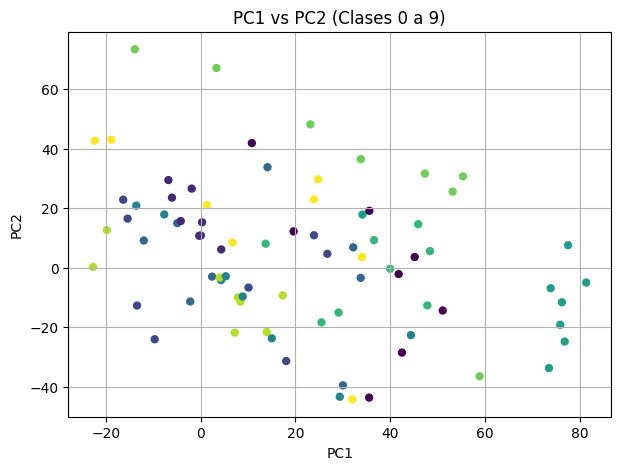

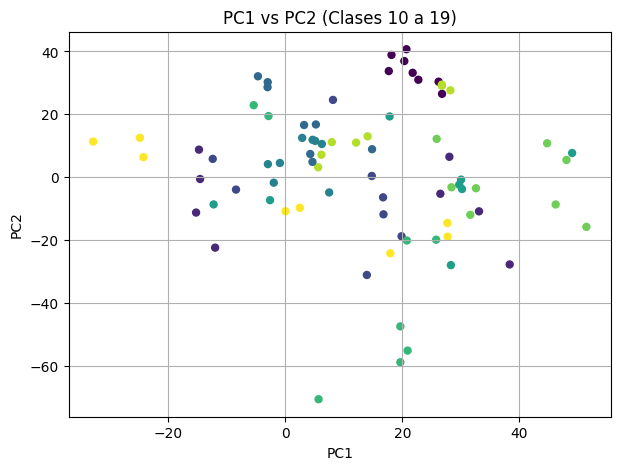

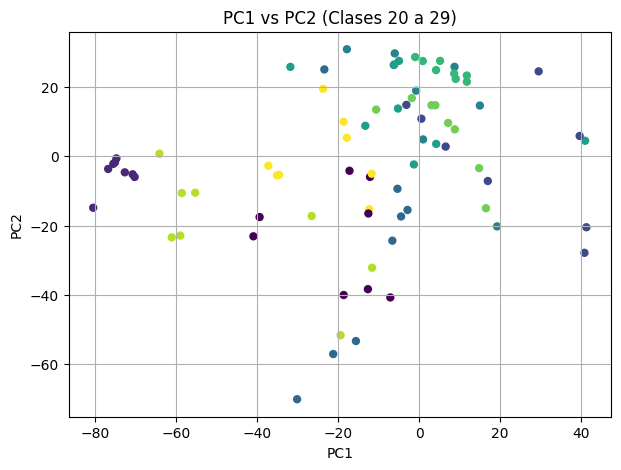

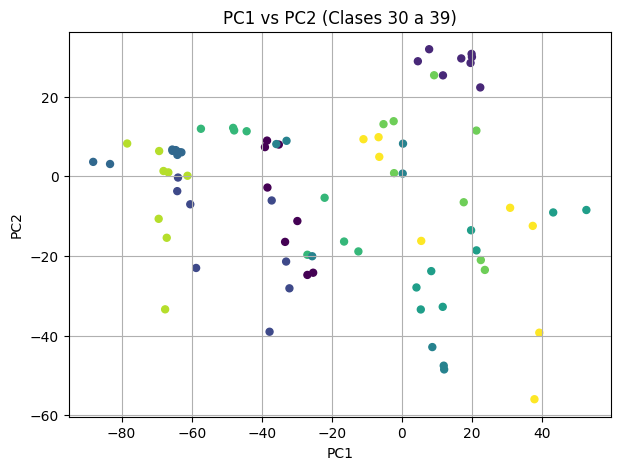

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Usamos la PCA elegida en la Parte 2
n_comp_part2 = 32  # <- tu elección final Parte 2

# Pipeline para escalar + PCA (solo para visualizar)
pipe_vis = Pipeline(steps=[
    ("scaler", StandardScaler()),                 # estandariza
    ("pca", PCA(n_components=n_comp_part2, random_state=42))  # PCA elegida
])

# Transformamos X_train a espacio PCA
Z_train = pipe_vis.fit_transform(X_train)         # ahora cada muestra tiene componentes PCA
pc1 = Z_train[:, 0]                               # componente principal 1
pc2 = Z_train[:, 1]                               # componente principal 2

def scatter_by_class_group(start_class, end_class):
    """
    Dibuja un scatter PC1 vs PC2 SOLO para clases entre start_class y end_class (incluidas).
    """
    mask = (y_train >= start_class) & (y_train <= end_class)  # filtra clases
    
    plt.figure(figsize=(7,5))
    plt.scatter(pc1[mask], pc2[mask], c=y_train[mask], s=25)  # colorea por clase
    plt.title(f"PC1 vs PC2 (Clases {start_class} a {end_class})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

# 4 gráficos: 0-9, 10-19, 20-29, 30-39
scatter_by_class_group(0, 9)
scatter_by_class_group(10, 19)
scatter_by_class_group(20, 29)
scatter_by_class_group(30, 39)


Se visualizan las dos primeras componentes principales (PC1 y PC2) de la PCA seleccionada en la Parte 2 (32 componentes). Se generan 4 scatter plots agrupando 10 clases por figura para observar cómo se distribuyen las identidades faciales en el espacio reducido.


PCA n_components = 4


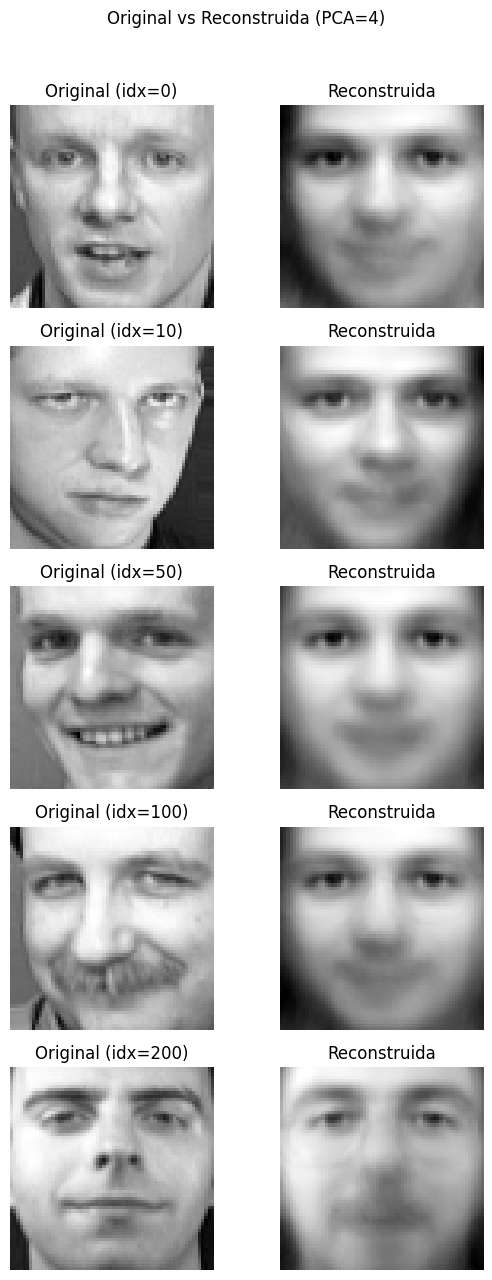


PCA n_components = 8


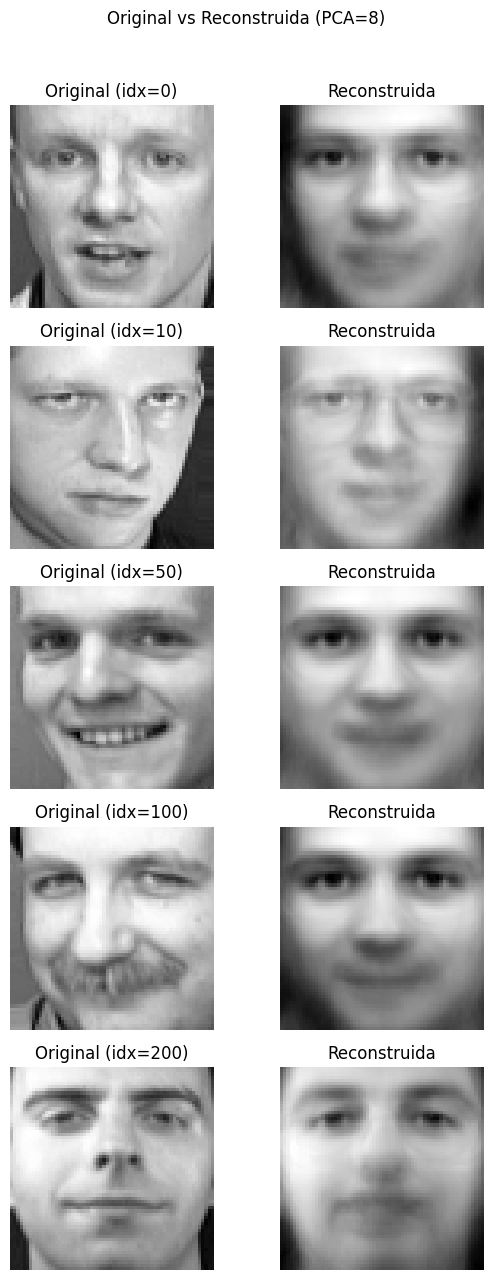


PCA n_components = 16


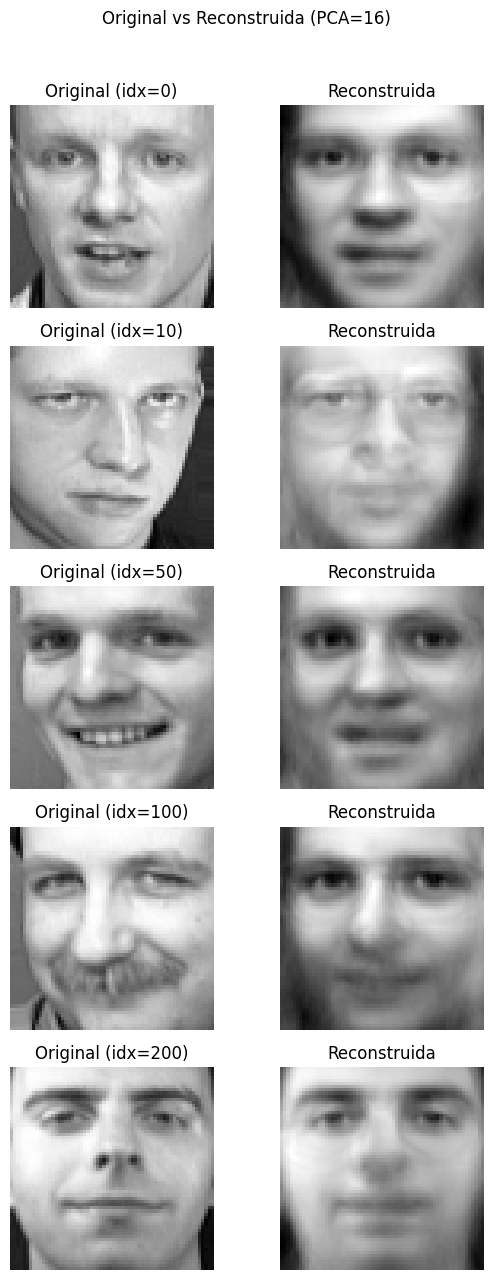


PCA n_components = 24


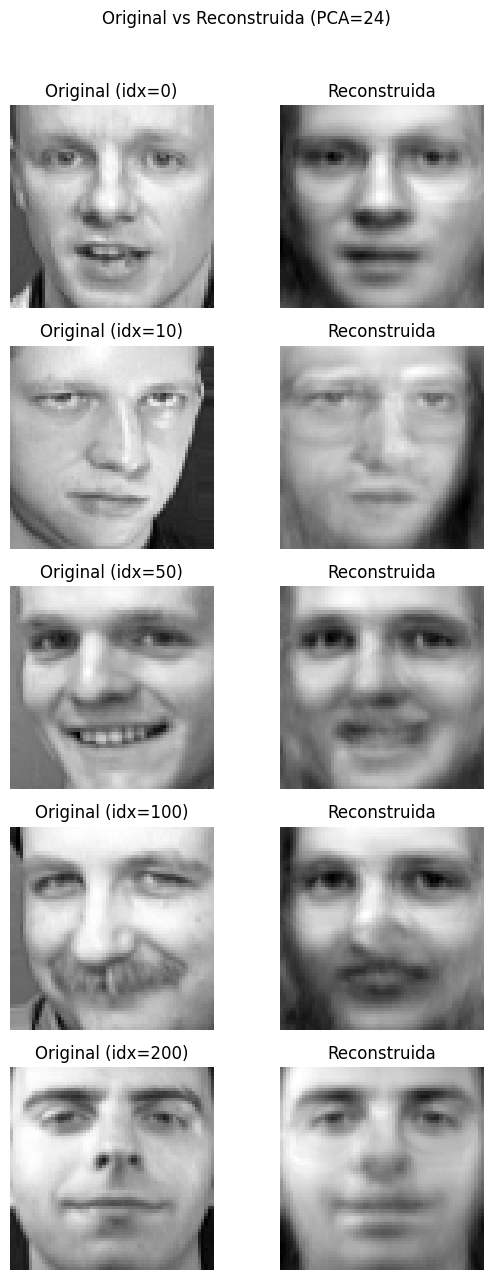


PCA n_components = 32


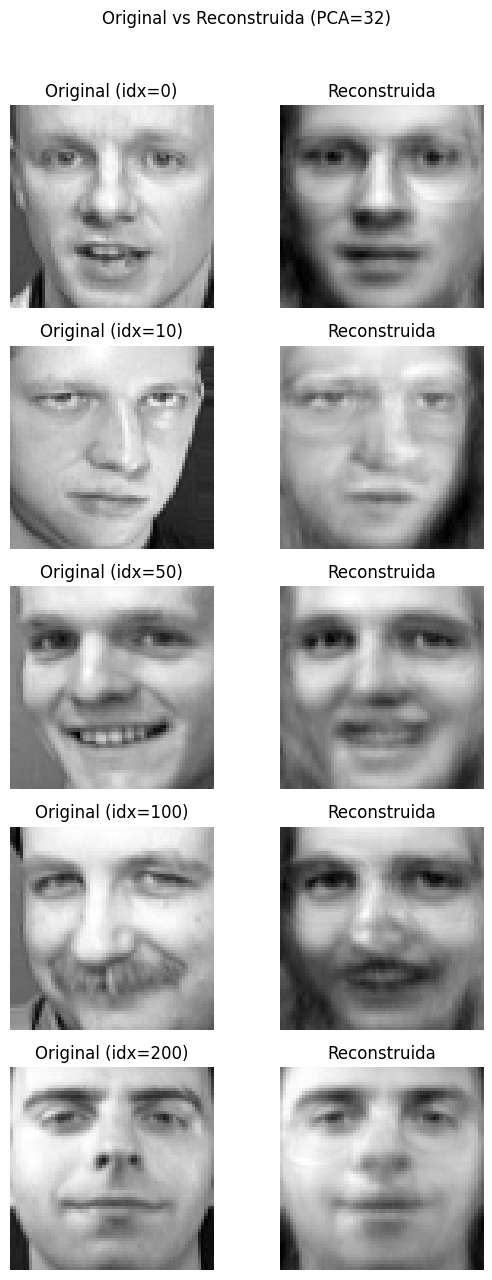


PCA n_components = 150


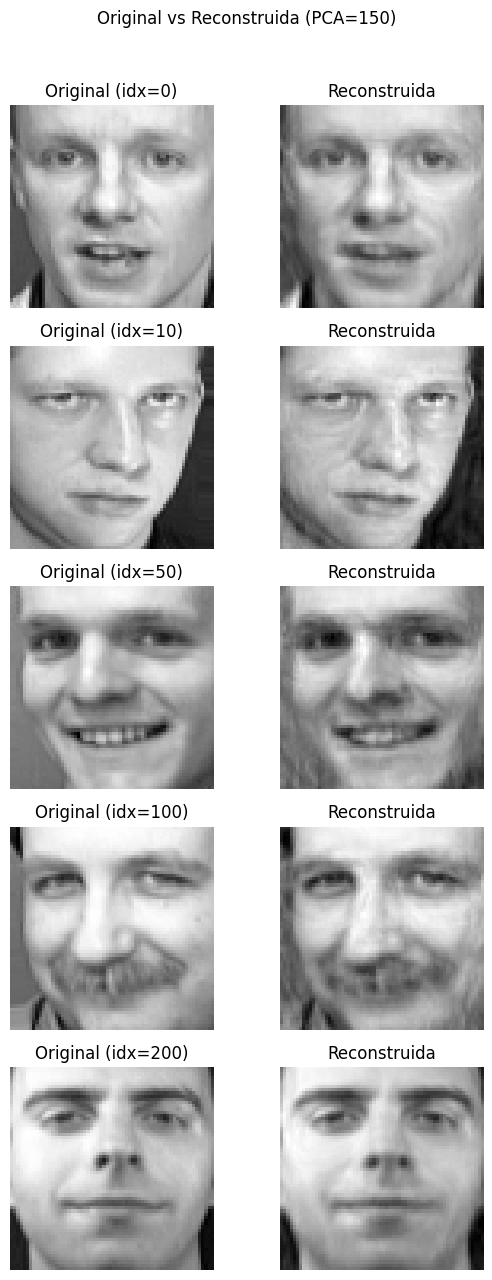


PCA n_components = 320


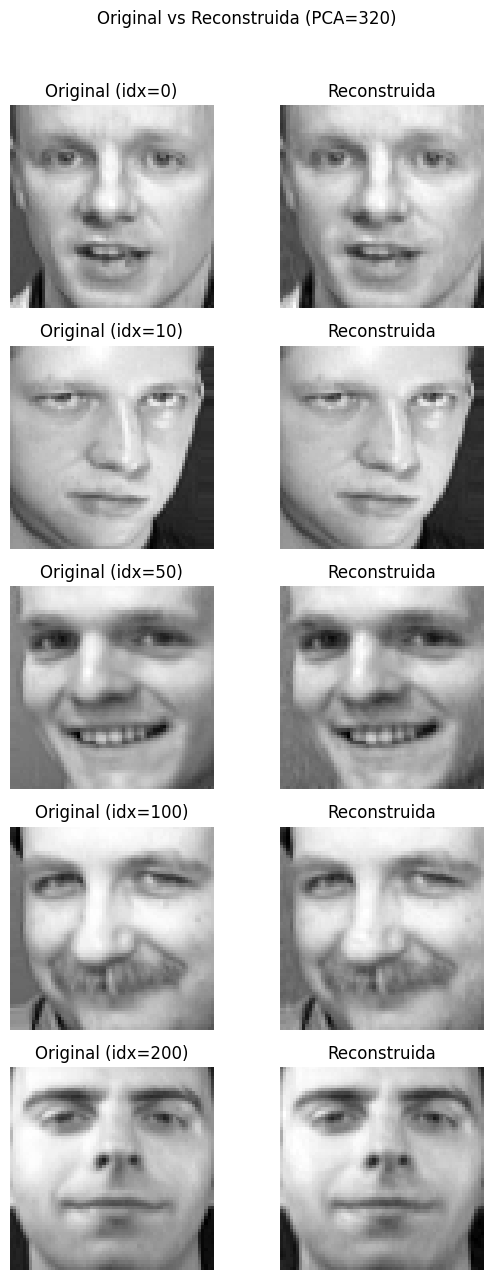

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Si no tienes X_all, créalo así:
X_all = df.drop(columns="target").values
y_all = df["target"].values

def show_faces_reconstruction(indices, n_components_list, X_data):
    """
    Muestra (por cada PCA n) las caras originales y reconstruidas para varios índices.
    
    indices: lista de índices de imágenes (ej: [0, 10, 50, 100, 200])
    n_components_list: lista de valores PCA a probar (ej: [4, 8, 16, 24, 32, 150, 320])
    X_data: matriz (n_samples, 4096) con las imágenes (valores de píxel)
    """
    # 1) Escalamos UNA vez para aplicar PCA correctamente
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X_data)

    for n_comp in n_components_list:
        # 2) Entrenamos PCA con n_comp y reconstruimos
        pca = PCA(n_components=n_comp, random_state=42)
        Z = pca.fit_transform(X_sc)              # comprimimos
        X_rec_sc = pca.inverse_transform(Z)      # descomprimimos (reconstruimos)

        print(f"\nPCA n_components = {n_comp}")

        # 3) Dibujar 5 ejemplos
        fig, axes = plt.subplots(len(indices), 2, figsize=(6, 2.5*len(indices)))
        fig.suptitle(f"Original vs Reconstruida (PCA={n_comp})", y=1.02)

        for i, idx in enumerate(indices):
            # Original (sin escalar, para verla bien)
            original = X_data[idx].reshape(64, 64)

            # Reconstruida (está en escala estandarizada -> la devolvemos a escala original)
            reconstructed = scaler.inverse_transform(X_rec_sc[idx].reshape(1, -1)).reshape(64, 64)

            # Columna 1: original
            axes[i, 0].imshow(original, cmap="gray")
            axes[i, 0].set_title(f"Original (idx={idx})")
            axes[i, 0].axis("off")

            # Columna 2: reconstruida
            axes[i, 1].imshow(reconstructed, cmap="gray")
            axes[i, 1].set_title("Reconstruida")
            axes[i, 1].axis("off")

        plt.tight_layout()
        plt.show()

# 5 caras (elige índices fijos para comparar siempre lo mismo)
indices = [0, 10, 50, 100, 200]

# Valores probados en parte 3 (los tuyos) + 150 y 320
n_list = [4, 8, 16, 24, 32, 150, 320]

show_faces_reconstruction(indices, n_list, X_all)


Se implementa una función que compara la imagen original con la reconstrucción obtenida tras comprimir y descomprimir mediante PCA (inverse_transform). Se visualizan 5 caras para cada número de componentes probado en la Parte 3, y se añaden los casos de 150 y 320 componentes para observar que con más componentes la reconstrucción mantiene mayor detalle y las caras se ven más nítidas.